The following examples use images from the [KIMIA Path960](https://www.kaggle.com/datasets/ambarish/kimia-path-960) dataset. This dataset contains multiple stains and tissue types which the authors have organized into groups, prefixed with a letter in the filename (i.e. `A0.tif`). Here, we will walk through unmixing and evaluating augmentation results on group J (hematoxylin and DAB), and K (hematoxylin and eosin).

In [13]:
from torchunmix.augment import plot_mixture, plot_ranges
from torchunmix.auto import Unmix

from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import numpy as np
import torch

## Data

First, we'll build a PyTorch `DataLoader` which we will use to feed the batched image data to TorchUnmix.

In [14]:
class KIMIADataset(Dataset):
    def __init__(self, images_dir: str, prefix: str):
        images_dir = Path(images_dir)
        self.image_paths = list(images_dir.glob('%s*.tif' % prefix))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        return torch.from_numpy(np.array(Image.open(path))[:, :, :3]).permute(2, 0, 1)

## Unmix: J (Hematoxylin and DAB)

Load in the "J" images from the dataset into a PyTorch `DataLoader`.

Because the number of images in each group is relatively small, we batch the entire group at once. In normal use cases, you would set your batch size to a value your GPU memory can handle given the image tile size and count.

In [15]:
ds = KIMIADataset('KIMIA', 'J')
dl = DataLoader(ds, batch_size=len(ds), shuffle=True)

Perform the unmixing across the images and then plot the clusters on a chromacity triangle.

We're using a whitespace `threshold` so background values aren't included in the clustering, and a centroid distance `percentile` which determines which tiles to keep for stain vector calculation (see Geijs et al. for more details).

100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


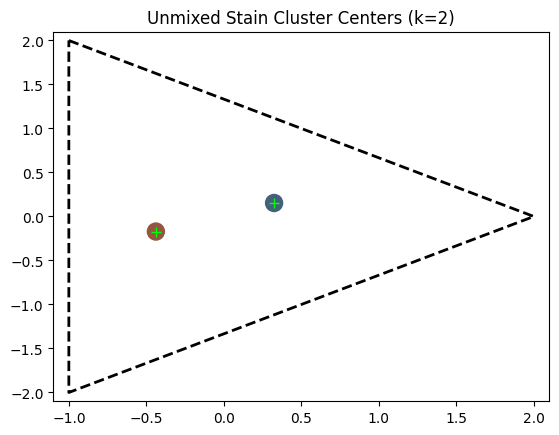

In [16]:
unmix = Unmix(dl, threshold=0.3, percentile=0.99, device='cuda:0', num_clusters=2)
unmix.plot()

Now we can obtain the stain vectors from the unmixing step.

In [17]:
rgb_to_hex, hex_to_rgb = unmix.stains()

Using the stain vectors, we can begin to evaluate appropriate ranges to use for stain augmentation.

The first way we can do this is by plotting a range of augmentation values and observing their *independent* effect upon the image.

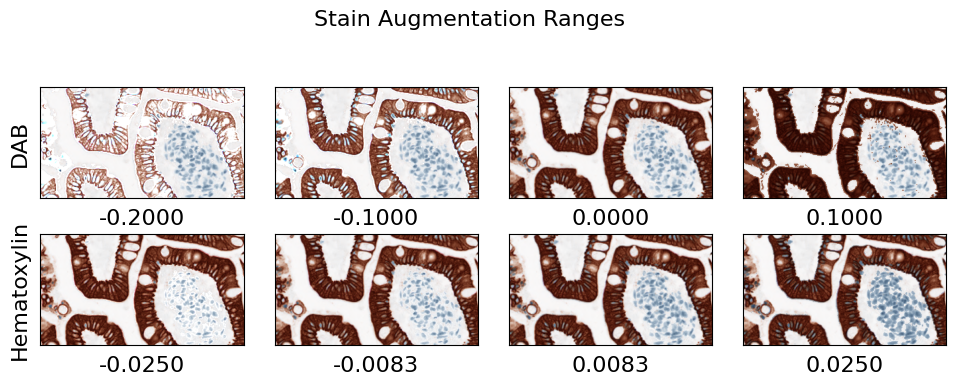

In [18]:
# set the ranges for each stain
ranges = ((-0.2, 0.1), (-0.025, 0.025))
# we will plot 4 evenly spaced intervals over the ranges
steps = 4
fig, ax = plot_ranges(ds[2].cuda(), rgb_to_hex, hex_to_rgb,  ranges, steps,
                      labels=['DAB', 'Hematoxylin'], fontsize=16, threshold=0.01)
fig.set_figheight(4)
fig.set_figwidth(10)

Similarly, we can evaluate the mixture of two stain augmentation ranges and plot them for visualization.

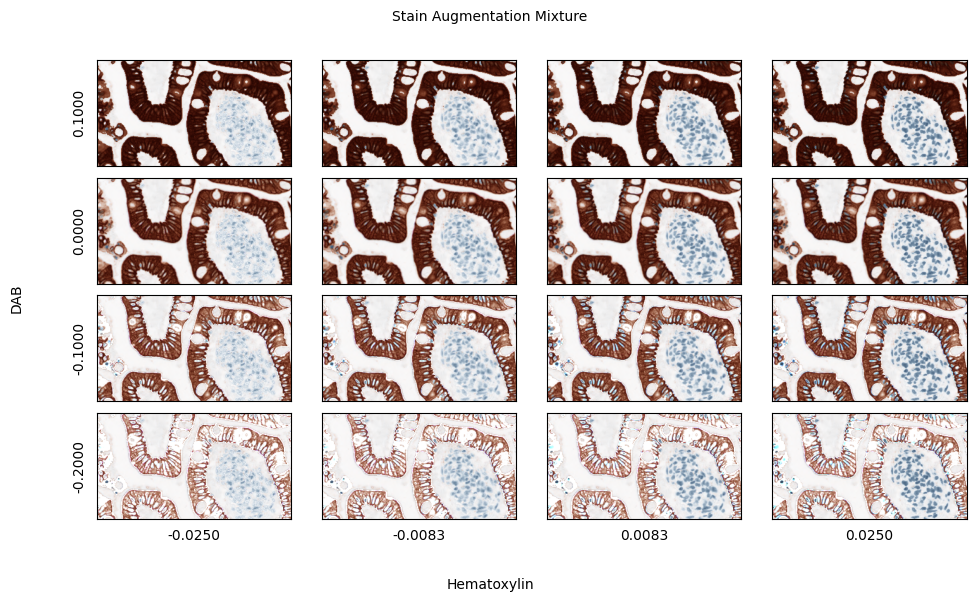

In [19]:
fig, ax = plot_mixture(ds[2].cuda(), rgb_to_hex, hex_to_rgb,  ranges, steps, (0, 1),
                      labels=['DAB', 'Hematoxylin'], fontsize=10, threshold=0.03)
fig.set_figheight(6)
fig.set_figwidth(10)

## Unmix: K (Hematoxylin & Eosin)

100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


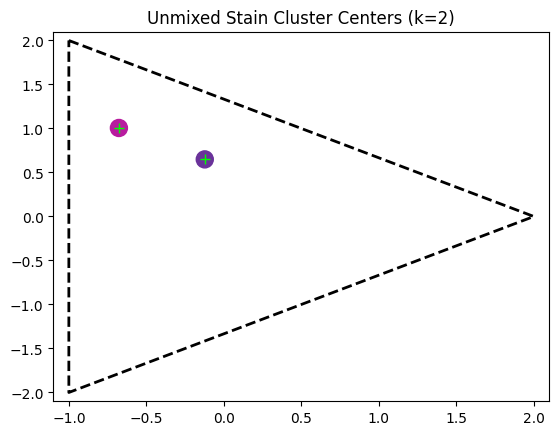

In [20]:
ds = KIMIADataset('KIMIA', 'K')
dl = DataLoader(ds, batch_size=len(ds), shuffle=True)
unmix = Unmix(dl, threshold=0.3, percentile=0.99, device='cuda:0', num_clusters=2)
fig = unmix.plot()

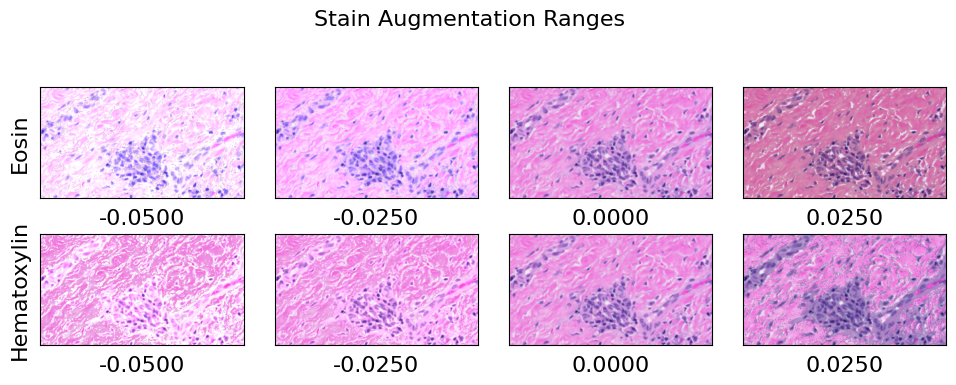

In [21]:
# set the ranges for each stain
ranges = ((-0.05, 0.025), (-0.05, 0.025))
# we will plot 4 evenly spaced intervals over the ranges
steps = 4
fig, ax = plot_ranges(ds[22].cuda(), rgb_to_hex, hex_to_rgb,  ranges, steps,
                      labels=['Eosin', 'Hematoxylin'], fontsize=16, threshold=0.01)
fig.set_figheight(4)
fig.set_figwidth(10)

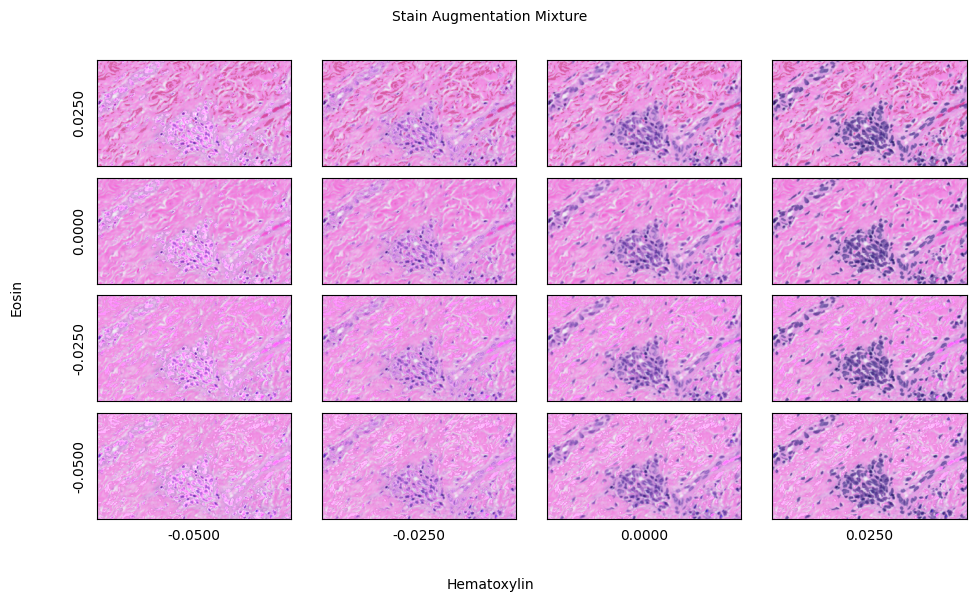

In [23]:
fig, ax = plot_mixture(ds[22].cuda(), rgb_to_hex, hex_to_rgb,  ranges, steps, (0, 1),
                      labels=['Eosin', 'Hematoxylin'], fontsize=10, threshold=0.03)
fig.set_figheight(6)
fig.set_figwidth(10)